In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance
pd.set_option('display.max_columns', None)


from lightgbm.sklearn import LGBMRegressor
from lightgbm.sklearn import LGBMClassifier

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

import math


In [2]:
import random, os 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #pythonhashseed 환경변수 설정
    np.random.seed(seed)

seed_everything(42)

In [3]:
data = pd.read_csv("/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/data/0122_total_data.csv")

In [4]:
train = data[data['is_test'] == 0]
test = data[data['is_test'] == 1]

In [5]:
train = train.sort_values(by='index')
test = test.sort_values(by='index')

In [6]:
train = train.set_index('index')
test = test.set_index('index')

In [7]:
train.drop(columns='is_test', inplace=True)
test.drop(columns='is_test', inplace=True)

In [8]:
drop_cols = ['이전가격','계약일','도로명주소','도로명_x','mean_높이','bus_min_dist','sub_min_dist','소비자전세물가지수','소비자월세물가지수','총인구수','연GDP','bus_count_1500','bus_count_2000','도로명','도로명_split','전용면적_filtered','매매수급동향','주차대수','k-전체세대수','세대수당_주차대수','년도별_세대수당_평균_주차대수','건물나이','2016_ratio','2017_ratio','2018_ratio','2019_ratio','2021_ratio','2022_ratio','2023_ratio']
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [9]:
train.shape, test.shape

((1118822, 31), (9272, 31))

In [10]:
train['구'] = train['시군구'].apply(lambda x: x.split()[1])
test['구'] = test['시군구'].apply(lambda x: x.split()[1])
train.drop(columns=['시군구'], inplace=True)
test.drop(columns=['시군구'], inplace=True)

In [11]:
train = train[(train['계약년월'] >= 202001) & (train['target'] < 300000)]
train.shape

(153831, 31)

In [12]:
train['층'] = train['층'].apply(lambda x: abs(x))
test['층'] = test['층'].apply(lambda x: abs(x))

In [13]:
train.shape, test.shape

((153831, 31), (9272, 31))

In [14]:
len(train[train['계약년월']<=202212]), len(train[train['계약년월']>202212])

(136666, 17165)

In [15]:
categorical_features = list(train.dtypes[train.dtypes == "object"].index) #object값 list에 넣음
# 추출된 문자열 변수 확인
display(categorical_features) #object값 출력

['복도유형', '난방방식', '아파트명', '동', '구']

In [16]:
def label_encoding(train_x, test, categorical_features):
    # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
    label_encoders = {}

    # Implement Label Encoding
    for col in tqdm( categorical_features ):
        lbl = LabelEncoder()

        # Label-Encoding을 fit
        lbl.fit(train_x[col].astype(str) )
        train_x[col] = lbl.transform(train_x[col].astype(str))
        label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

        # # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
        for label in np.unique(test[col]):
            if label not in lbl.classes_: # unseen label 데이터인 경우
                lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

        test[col] = lbl.transform(test[col].astype(str))
    
    return label_encoders

label_encoders = label_encoding(train_x=train, test=test, categorical_features=categorical_features)

100%|██████████| 5/5 [00:00<00:00, 17.24it/s]


In [17]:
train.columns

Index(['복도유형', '난방방식', '전용면적', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'sum_건축면적', 'mean_건축면적',
       '부속건축물수', 'target', '동', '한강거리', '기준금리', 'dist_to_nearest_school',
       'bus_count_500', 'bus_count_1000', 'is_station_area', '대장아파트_거리', '최고층',
       '최저층', '빌딩간격', '거래날차이', '2020_ratio', '구'],
      dtype='object')

## LightGBM 30억 미만 예측

In [39]:
X_train = train[train['계약년월'] <= 202212]
y_train = X_train['target']
X_train.drop(columns=['target'], inplace=True)


X_val = train[(train['계약년월'] >= 202301) & (train['계약년월'] <= 202303)]
y_val = X_val['target']
X_val.drop(columns=['target'], inplace=True)

X_train_all = train[train['계약년월'] <= 202303]
y_train_all = X_train_all['target']
X_train_all.drop(columns=['target'], inplace=True)

X_test = train[(train['계약년월'] >= 202304) & (train['계약년월'] <= 202306)]
y_test = X_test['target']
X_test.drop(columns=['target'], inplace=True)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((136666, 30), (136666,), (6798, 30), (6798,), (10367, 30), (10367,))

In [19]:
evaluation_metric = mean_squared_error

In [20]:
# 하이퍼 파라미터 조정하지 않고 모델 성능 체크
model = LGBMRegressor()
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4475
[LightGBM] [Info] Number of data points in the train set: 136666, number of used features: 30
[LightGBM] [Info] Start training from score 86563.365533


LGBMRegressor()

In [21]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

train_score = np.sqrt(evaluation_metric(y_train, pred_train))
val_score = np.sqrt(evaluation_metric(y_val, pred_val))
test_score = np.sqrt(evaluation_metric(y_test, pred_test))

print("Train Score : %.4f" % train_score)
print("Valid Score : %.4f" % val_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 11129.8078
Valid Score : 13101.2657
Test Score : 14701.9578


In [22]:
def optimizer(trial):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    num_leaves = trial.suggest_categorical('num_leaves', [2**9-1, 2**10-1, 2**11-1, 2**12-1])
    max_depth = trial.suggest_int('max_depth', 13, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 25)
    reg_lambda = trial.suggest_float('reg_lambda', 5.0, 20.0)
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.5, 0.7])

    model = LGBMRegressor(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          n_estimators=n_estimators,
                          min_child_samples=min_child_samples,
                          reg_lambda=reg_lambda,
                          colsample_bytree=colsample_bytree,
                          random_state=42,
                          verbose=-1)

    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    loss = evaluation_metric(y_val, preds)

    return loss

In [24]:
opt_func = partial(optimizer)
study = optuna.create_study(direction="minimize")
study.optimize(opt_func, n_trials=300)

[I 2024-01-24 06:04:26,714] A new study created in memory with name: no-name-8a553bf4-b158-45c5-97ee-91d34d122b2a
[I 2024-01-24 06:04:30,973] Trial 0 finished with value: 102673427.04694664 and parameters: {'num_leaves': 511, 'max_depth': 13, 'learning_rate': 0.05558402510769302, 'n_estimators': 171, 'min_child_samples': 19, 'reg_lambda': 16.539768384786974, 'colsample_bytree': 0.7}. Best is trial 0 with value: 102673427.04694664.
[I 2024-01-24 06:04:40,952] Trial 1 finished with value: 103113248.14998941 and parameters: {'num_leaves': 4095, 'max_depth': 16, 'learning_rate': 0.07782828884948054, 'n_estimators': 181, 'min_child_samples': 16, 'reg_lambda': 18.866217426995284, 'colsample_bytree': 0.7}. Best is trial 0 with value: 102673427.04694664.
[I 2024-01-24 06:04:52,196] Trial 2 finished with value: 241850152.25105184 and parameters: {'num_leaves': 4095, 'max_depth': 17, 'learning_rate': 0.014783338711983621, 'n_estimators': 134, 'min_child_samples': 12, 'reg_lambda': 17.98001922002

In [25]:
# 1st tunning
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 94171756.3268
Best params:  {'num_leaves': 511, 'max_depth': 15, 'learning_rate': 0.09367188475966383, 'n_estimators': 194, 'min_child_samples': 12, 'reg_lambda': 7.011248660860715, 'colsample_bytree': 0.5}


In [26]:
# model finalization
best_params = study.best_params
best_model = LGBMRegressor(**best_params,
                          random_state=42,
                          verbose=-1)

best_model.fit(X_train, y_train)

pred_train = best_model.predict(X_train)
pred_val = best_model.predict(X_val)
pred_test = best_model.predict(X_test)

train_score = np.sqrt(evaluation_metric(y_train, pred_train))
val_score = np.sqrt(evaluation_metric(y_val, pred_val))
test_score = np.sqrt(evaluation_metric(y_test, pred_test))

print("Train Score : %.4f" % train_score)
print("Valid Score : %.4f" % val_score)
print("Test Score : %.4f" % test_score)

Train Score : 4412.8290
Valid Score : 9704.2133
Test Score : 12333.9627


                   Feature  Importance
2                     전용면적        5334
27                   거래날차이        5113
4                     건축년도        5016
5                        x        4696
17                    한강거리        4657
6                        y        4367
23                대장아파트_거리        4310
14               mean_건축면적        4298
7                     아파트명        4247
3                        층        4180
10                 sum_세대수        4042
21          bus_count_1000        4001
8                     계약년월        3963
11                 sum_연면적        3857
9                mean_지상층수        3839
12                mean_연면적        3820
16                       동        3781
19  dist_to_nearest_school        3543
13                sum_건축면적        3484
20           bus_count_500        3373
24                     최고층        2331
26                    빌딩간격        2322
15                  부속건축물수        2115
28              2020_ratio        2054
29                       

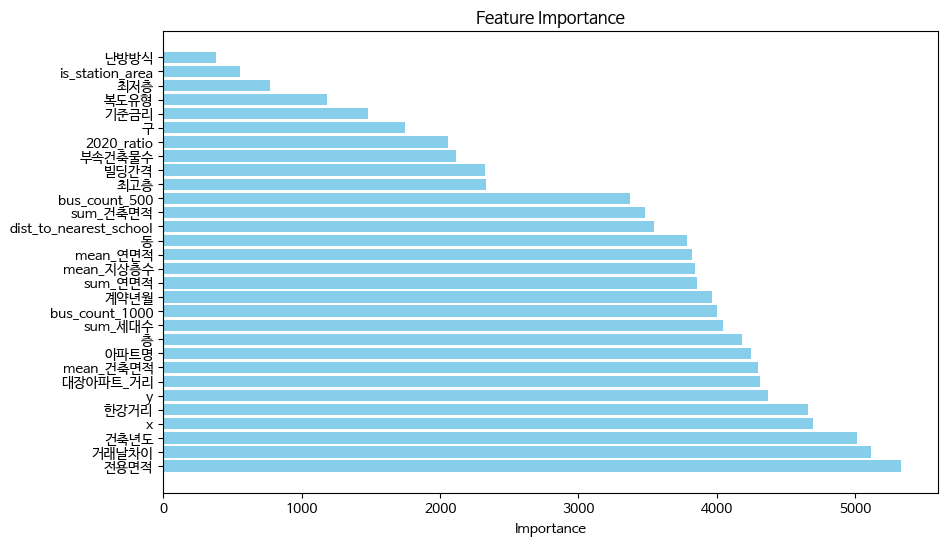

In [27]:
feature_importance = best_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(feature_importance_df)

# Optionally, plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [28]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

In [29]:
X_train['target'] = y_train
X_train['pred'] = pred_train

X_val['target'] = y_val
X_val['pred'] = pred_val



# RMSE 계산
train_squared_errors = calculate_se(X_train['target'], X_train['pred'])
val_squared_errors = calculate_se(X_val['target'], X_val['pred'])


X_train['error'] = train_squared_errors
X_val['error'] = val_squared_errors

# Error가 큰 순서대로 sorting 해 보겠습니다.
X_train_sort = X_train.sort_values(by='error', ascending=False) 
X_val_sort = X_val.sort_values(by='error', ascending=False) 

In [30]:
X_train_sort[['target', 'pred', 'error']].head(20)

,target,pred,error
index,,,
914460,100000.0,192255.781084,8.511129e+09
734413,160150.0,240583.373949,6.469528e+09
737063,160000.0,239758.708090,6.361452e+09
734404,166250.0,244789.227406,6.168410e+09
6941,160000.0,233550.443348,5.409668e+09
3865,77500.0,142588.178063,4.236471e+09
768312,104500.0,169541.972116,4.230458e+09
26774,136000.0,200950.982089,4.218630e+09
898363,120500.0,185255.318445,4.193251e+09


In [31]:
X_train_sort[['target', 'pred', 'error']].tail(20)

,target,pred,error
index,,,
187805,45700.0,45699.486360,0.263826
543764,31500.0,31499.490662,0.259425
159813,72500.0,72499.500405,0.249595
446254,24500.0,24499.524736,0.225876
580637,21700.0,21699.611085,0.151255
520174,75500.0,75500.372020,0.138399
529193,125500.0,125499.661101,0.114852
244016,55800.0,55800.320730,0.102868
226709,75800.0,75800.283350,0.080287


In [32]:
X_val_sort[['target', 'pred', 'error']].head(20)

,target,pred,error
index,,,
1068129,285000.0,179605.621235,1.110798e+10
780809,299000.0,212079.076740,7.555247e+09
1016271,282000.0,209915.080258,5.196236e+09
414879,151000.0,219148.523814,4.644221e+09
775926,284000.0,217468.770557,4.426404e+09
25787,96000.0,162491.862095,4.421168e+09
1077518,228000.0,167333.188962,3.680462e+09
775166,175600.0,115732.349331,3.584136e+09
114696,50000.0,108676.084189,3.442883e+09


In [33]:
X_val_sort[['target', 'pred', 'error']].tail(20)

,target,pred,error
index,,,
1092552,34000.0,34018.738257,351.122279
132224,72800.0,72816.824052,283.048736
184231,94000.0,93983.354172,277.083587
723566,159000.0,159015.109089,228.284584
275657,14900.0,14914.152627,200.296852
689766,148000.0,147986.221761,189.839876
423067,15000.0,14986.332435,186.802330
346620,25000.0,25012.804525,163.955852
131500,54000.0,53987.702104,151.238252


In [37]:
X_train_all.columns

Index(['복도유형', '난방방식', '전용면적', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'sum_건축면적', 'mean_건축면적',
       '부속건축물수', '동', '한강거리', '기준금리', 'dist_to_nearest_school',
       'bus_count_500', 'bus_count_1000', 'is_station_area', '대장아파트_거리', '최고층',
       '최저층', '빌딩간격', '거래날차이', '2020_ratio', '구'],
      dtype='object')

In [38]:
X_test.columns

Index(['복도유형', '난방방식', '전용면적', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'sum_건축면적', 'mean_건축면적',
       '부속건축물수', '동', '한강거리', '기준금리', 'dist_to_nearest_school',
       'bus_count_500', 'bus_count_1000', 'is_station_area', '대장아파트_거리', '최고층',
       '최저층', '빌딩간격', '거래날차이', '2020_ratio', '구', 'target', 'pred', 'error'],
      dtype='object')

In [40]:
best_params = study.best_params
best_model = LGBMRegressor(**best_params,
                          random_state=42,
                          verbose=-1)

best_model.fit(X_train_all, y_train_all)

pred_test = best_model.predict(X_test)

test_score = np.sqrt(evaluation_metric(y_test, pred_test))

print("Test Score : %.4f" % test_score)


Test Score : 10015.5281


In [41]:
X_test['target'] = y_test
X_test['pred'] = pred_test
test_squared_errors = calculate_se(X_test['target'], X_test['pred'])
X_test['error'] = test_squared_errors
X_test_sort = X_test.sort_values(by='error', ascending=False)

In [42]:
X_test_sort[['target', 'pred', 'error']].head(20)

,target,pred,error
index,,,
12493,279250.0,169889.788144,1.195966e+10
12491,214000.0,111373.762723,1.053214e+10
708105,240000.0,139251.528672,1.015025e+10
808498,290000.0,189527.574663,1.009471e+10
12492,210000.0,114990.738702,9.026760e+09
1077503,291000.0,198984.664632,8.466822e+09
1054669,182000.0,93885.427365,7.764178e+09
1077505,260000.0,172765.536806,7.609852e+09
1050521,207500.0,131488.361939,5.777769e+09


In [43]:
X_test_sort[['target', 'pred', 'error']].tail(20)

,target,pred,error
index,,,
902767,28700.0,28686.691035,177.128545
598650,38000.0,38013.178472,173.672114
657448,97000.0,97012.437961,154.702866
345468,23400.0,23412.168206,148.065246
558256,33300.0,33311.813133,139.550100
920686,167000.0,166988.753126,126.492172
1058437,56000.0,56010.532765,110.939132
221730,72000.0,72009.748828,95.039650
182282,50600.0,50609.430822,88.940411


In [50]:
X_val.columns

Index(['복도유형', '난방방식', '전용면적', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'sum_건축면적', 'mean_건축면적',
       '부속건축물수', '동', '한강거리', '기준금리', 'dist_to_nearest_school',
       'bus_count_500', 'bus_count_1000', 'is_station_area', '대장아파트_거리', '최고층',
       '최저층', '빌딩간격', '거래날차이', '2020_ratio', '구'],
      dtype='object')

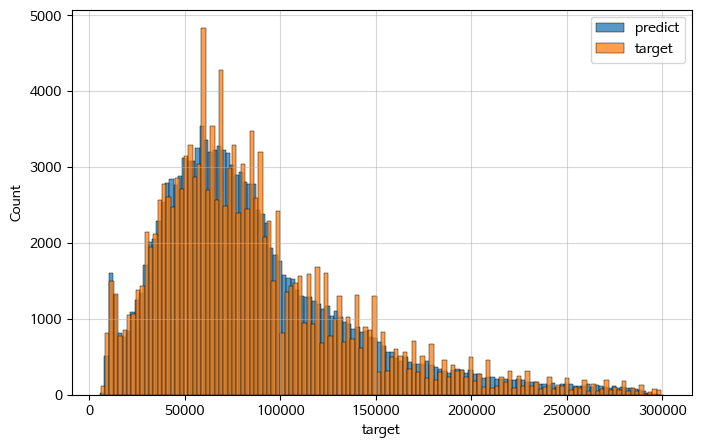

In [58]:
plt.figure(figsize=(8,5))
sns.histplot(data=X_train_sort, x='pred', label='predict')
sns.histplot(data=X_train_sort, x='target', label='target')
plt.ticklabel_format(axis='x', style='plain')
plt.xlabel('target')
plt.grid(alpha=0.5)
plt.legend()

plt.show()

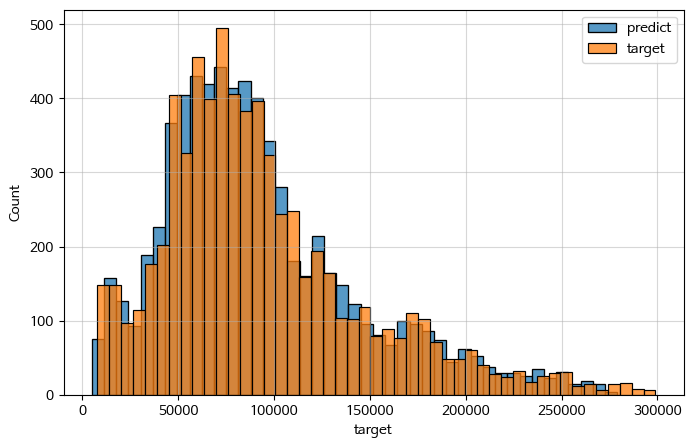

In [55]:
plt.figure(figsize=(8,5))
sns.histplot(data=X_val_sort, x='pred', label='predict')
sns.histplot(data=X_val_sort, x='target', label='target')
plt.ticklabel_format(axis='x', style='plain')
plt.xlabel('target')
plt.grid(alpha=0.5)
plt.legend()

plt.show()

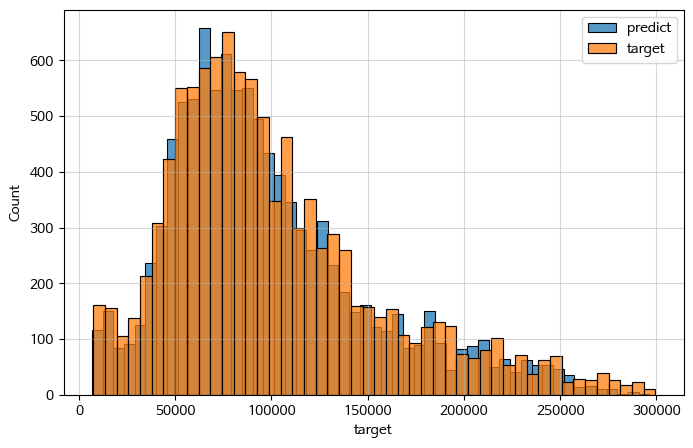

In [57]:
plt.figure(figsize=(8,5))
sns.histplot(data=X_test_sort, x='pred', label='predict')
sns.histplot(data=X_test_sort, x='target', label='target')
plt.ticklabel_format(axis='x', style='plain')
plt.xlabel('target')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [80]:
for column in categorical_features :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    X_val_sort[column] = label_encoders[column].inverse_transform(X_val_sort[column])

In [79]:
for column in categorical_features :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    X_test_sort[column] = label_encoders[column].inverse_transform(X_test_sort[column])

In [82]:
X_val_sort[['아파트명', 'target', 'pred']].head(20)

,아파트명,target,pred
index,,,
1068129,디팰리스,285000.0,179605.621235
780809,트리마제,299000.0,212079.076740
1016271,한남더힐,282000.0,209915.080258
414879,리버타워,151000.0,219148.523814
775926,서초그랑자이,284000.0,217468.770557
25787,에스케이허브젠,96000.0,162491.862095
1077518,장충레지던스,228000.0,167333.188962
775166,더샵반포리버파크,175600.0,115732.349331
114696,정산,50000.0,108676.084189


In [83]:
X_test_sort[['아파트명', 'target', 'pred']].head(20)

,아파트명,target,pred
index,,,
12493,개포자이프레지던스,279250.0,169889.788144
12491,개포자이프레지던스,214000.0,111373.762723
708105,동도아카데미하우스3차,240000.0,139251.528672
808498,옥수파크힐스101동~116동,290000.0,189527.574663
12492,개포자이프레지던스,210000.0,114990.738702
1077503,장충동라임카운티,291000.0,198984.664632
1054669,은평뉴타운 제각말 푸르지오,182000.0,93885.427365
1077505,장충동라임카운티,260000.0,172765.536806
1050521,우물골2단지두산위브BL2-8,207500.0,131488.361939


## Inference

In [17]:
train_x = train.drop(columns=['target'])
train_y = train['target']

In [18]:
best_params = {'num_leaves': 511, 
          'max_depth': 15, 
          'learning_rate': 0.09367188475966383, 
          'n_estimators': 194, 
          'min_child_samples': 12, 
          'reg_lambda': 7.011248660860715, 
          'colsample_bytree': 0.5}

best_model = LGBMRegressor(**best_params,
                          random_state=42,
                          verbose=-1)

best_model.fit(train_x, train_y)


LGBMRegressor(colsample_bytree=0.5, learning_rate=0.09367188475966383,
              max_depth=15, min_child_samples=12, n_estimators=194,
              num_leaves=511, random_state=42, reg_lambda=7.011248660860715,
              verbose=-1)

In [19]:
pred = best_model.predict(test[train_x.columns])
test.loc[:, 'target'] = pred 

In [20]:
submission = pd.read_csv("/data/ephemeral/home/sample_submission.csv")
submission.loc[:, 'target'] = (test.loc[:, 'target']).astype(int)
submission.to_csv("/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/under_30/sjh_submission_v1.csv", index=False)

In [21]:
submission['target'].describe()

count      9272.000000
mean     103192.691329
std       59774.388104
min        7933.000000
25%       62955.500000
50%       87549.500000
75%      126442.500000
max      316698.000000
Name: target, dtype: float64

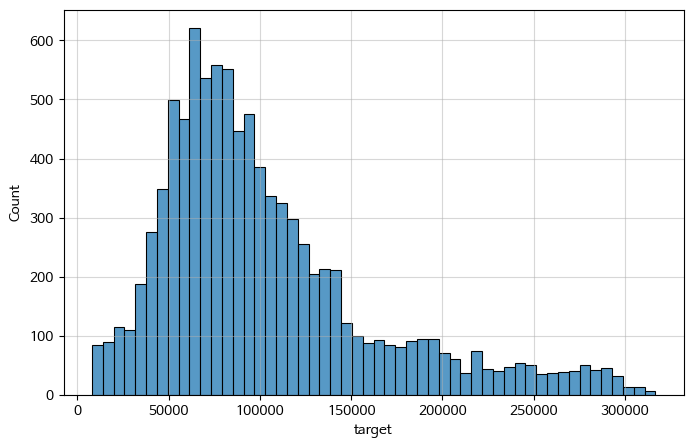

In [22]:
plt.figure(figsize=(8,5))
sns.histplot(data=submission, x='target')
plt.ticklabel_format(axis='x', style='plain')
plt.xlabel('target')
plt.grid(alpha=0.5)
plt.show()